# White noise fitting example (EFAC and EQUAD)

This notebook corresponds to Section 6.1 of Susobhanan+ 2024.

In [1]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise.signals.parameter import Uniform, LinearExp
from enterprise.signals.selections import Selection, no_selection

from pint.models import get_model_and_toas
from pint.fitter import Fitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion
from pint.output.publish import publish

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
from matplotlib import pyplot as plt
from copy import deepcopy

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
# Suppress annoying messages.
setup_log(level="WARNING")

1

In [3]:
m, t = get_model_and_toas("sim1.par", "sim1.tim", planets=True)

In [4]:
print(m)

# Created: 2024-05-31T13:47:49.527314
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
TZRMJD     

## Model comparison using AIC

What components are required? EFAC or EQUAD or both or neither?

In [5]:
result = np.zeros((2,2))
for eff in [True, False]:
    for eqf in [True, False]:
        m1 = deepcopy(m)
        m1.EFAC1.value = 1
        m1.EQUAD1.value = 1e-4
        m1.EFAC1.frozen = not eff
        m1.EQUAD1.frozen = not eqf

        ftr = Fitter.auto(t, m1)
        ftr.fit_toas(noise_fit_niter=5)

        fp = set(m1.free_params).intersection(["EFAC1", "EQUAD1"])
        
        result[int(not eff), int(not eqf)] = akaike_information_criterion(ftr.model, t)

print(np.round(result - np.min(result)))

[[   0.  198.]
 [  44. 5191.]]


AIC seems to favour EFAC + EQUAD.

## Fitting for EFAC and EQUAD using PINT

In [6]:
# Let us fit for both EFAC & EQUAD.
# The original model has both of them already. 
# So we can use it as it is.
ftr = Fitter.auto(t, m)
ftr.fit_toas()

In [7]:
# Look at the post-fit model.
# Both EFAC and EQUAD have been estimated, along with their uncertainties.
print(ftr.model)

# Created: 2024-05-31T13:48:09.576683
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567183797
FINISH             56985.0000000464162847
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2000.0000000061225
CHI2R                  1.0045203415399913
TRES                 2.413459136043241036
RAJ                      4:59:59.99999598 1 0.00000275770691301013
DECJ                    15:00:00.00027474 1 0.00023540335832146866
PMRA                                  0.0
PMDEC                  

## Bayesian parameter estimation using ENTERPRISE & PTMCMCSampler

In [8]:
psr = Pulsar(ftr.model, t)

In [9]:
tm = TimingModel()
wn = MeasurementNoise(efac=Uniform(0.5, 2.0), log10_t2equad=LinearExp(-8, -4))

In [10]:
model = tm + wn

In [11]:
pta = PTA([model(psr)])

In [12]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim1/"
Niter = 100000

In [13]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [14]:
sampler.sample(
    x0,
    Niter,
)

Finished 10.00 percent in 6.487989 s Acceptance rate = 0.10156Adding DE jump with weight 20
Finished 100.00 percent in 63.074152 s Acceptance rate = 0.26182
Run Complete


WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


In [15]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

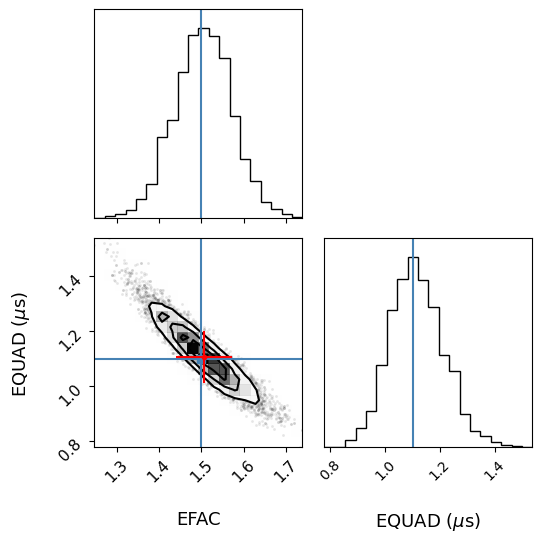

In [23]:
fig = corner.corner(
    burned_chain, 
    labels=["EFAC", "EQUAD ($\\mu$s)"], 
    truths=[m.EFAC1.value, m.EQUAD1.quantity.value],
    label_kwargs={"fontsize":13}
)

plt.subplot(223)
plt.errorbar(
    [ftr.model.EFAC1.value], 
    [ftr.model.EQUAD1.value],
    xerr=[ftr.model.EFAC1.uncertainty_value], 
    yerr=[ftr.model.EQUAD1.uncertainty_value],
    color="red",
    marker="."
)
plt.tick_params(axis="both", labelsize=11)
plt.tight_layout()
plt.savefig("sim1.pdf")

The ENTERPRISE and PINT estimates match really well!

New let's look at the post-fit residuals. It looks like white noise, as it should.

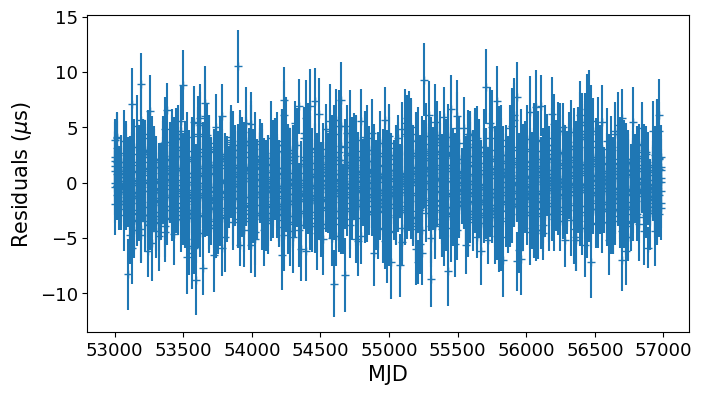

In [28]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)", fontsize=15)
plt.xlabel("MJD", fontsize=15)
plt.tight_layout()
plt.tick_params(axis="both", labelsize=13)
plt.savefig("sim1-resids.pdf")